### Radar Graphs
This was a failed idea to vizualize performance through an overlapping radar graph

In [3]:
from utils.all import *

# There's also 'tutorial' and 'preliminary' data
data = load_data('../annotated', batch_num=[5, 6], preprocess=True)

Loading files: ['../annotated/batch_5_anton.json', '../annotated/batch_5_ayush.json', '../annotated/batch_5_kelly.json', '../annotated/batch_5_rachel.json', '../annotated/batch_5_vinayak.json', '../annotated/batch_5_vishnesh.json', '../annotated/batch_6_anton.json', '../annotated/batch_6_ayush.json', '../annotated/batch_6_kelly.json', '../annotated/batch_6_rachel.json', '../annotated/batch_6_vinayak.json', '../annotated/batch_6_vishnesh.json']

Found users: {'vinayak', 'anton', 'kelly', 'ayush', 'rachel', 'vishnesh'}

anton - Batch 5, HIT 38 (ID 37) has 2 deletion edits but 1 annotations. Likely a missing annotation. Skipping edit type...
vinayak - Batch 6, HIT 16 (ID 45) has 1 insertion edits but -1 annotations. Likely a missing annotation. Skipping edit type...
rachel - Batch 5, HIT 21 (ID 65) has 4 deletion edits but 3 annotations. Likely a missing annotation. Skipping edit type...
rachel - Batch 5, HIT 21 (ID 65) has 4 insertion edits but 3 annotations. Likely a missing annotation.

In [4]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

colors = ['b', 'r', 'g', 'm', 'y']

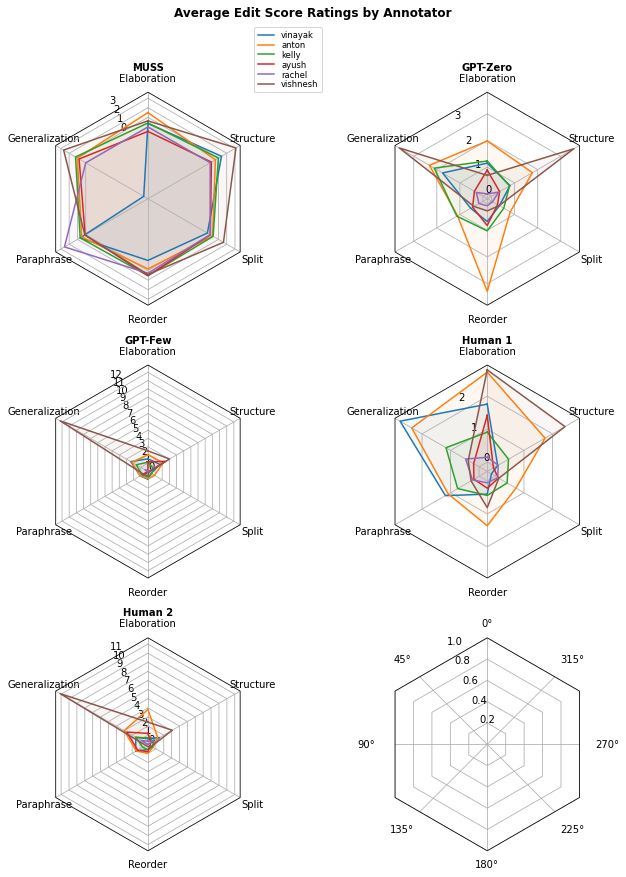

In [5]:
class Tmp(Enum):
    PARAPHRASE = 'Paraphrase'

# We'll start with the average score, which takes into account errors
out = {}
for system in set([x['system'] for x in data]):
    sys = {}

    for annotator in set([x['user'] for x in data]):
        annotator_data = [sent for sent in data if sent['user'] == annotator and sent['system'] == system]
        anns = [i for j  in [sent['processed_annotations'] for sent in annotator_data] for i in j]

        sys[annotator] = {
            Information.MORE: avg([ann['score'] for ann in anns if ann['information_impact'] == Information.MORE]),
            Information.LESS: avg([ann['score'] for ann in anns if ann['information_impact'] == Information.LESS]),
            Tmp.PARAPHRASE: avg([ann['score'] for ann in anns if ann['information_impact'] == Information.SAME and ann['edit_type'] == 'substitution']),
            Edit.REORDER: avg([ann['score'] for ann in anns if ann['edit_type'] == 'reorder']),
            Edit.SPLIT: avg([ann['score'] for ann in anns if ann['edit_type'] == 'split']) / 10,
            Edit.STRUCTURE: avg([ann['score'] for ann in anns if ann['edit_type'] == 'structure']),
        }
    
    out[system] = sys

spokes = list(out[list(out.keys())[0]][list(out[list(out.keys())[0]].keys())[0]].keys())
annotators = list(out[list(out.keys())[0]].keys())

plot_data = [spokes]
for system in [x for x in system_name_mapping if x in out.keys()]:
    sys_data = []
    for annotator in out[system].keys():
        sys_data += [[out[system][annotator][spoke] for spoke in spokes]]
    plot_data += [(system_name_mapping[system], [sys_data])]

# PLOTS

N = len(spokes)
theta = radar_factory(N, frame='polygon')
spoke_labels = [x.value for x in plot_data.pop(0)]

fig, axs = plt.subplots(figsize=(9, 12), nrows=3, ncols=2,
        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axs.flat, plot_data):
    ax.set_rgrids([i for i in range(0, 15)])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                    horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d) # color=color
        ax.fill(theta, d, alpha=0.05, label='_nolegend_') # facecolor=color
    ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot
legend = axs[0, 0].legend(annotators, loc=(1, 1), labelspacing=0.1, fontsize='small')

fig.text(0.5, 1, 'Average Edit Score Ratings by Annotator',
        horizontalalignment='center', color='black', weight='bold', size='large')

plt.show()

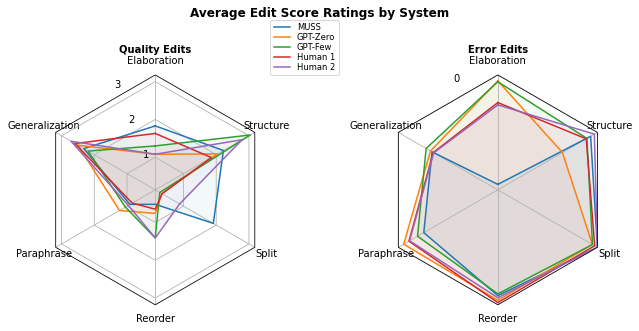

In [6]:
# Separate quality and error charts
out = {}

sys = {}

for system in set([x['system'] for x in data]):
    annotator_data = [sent for sent in data if sent['system'] == system]
    anns = [i for j  in [sent['processed_annotations'] for sent in annotator_data] for i in j if i['type'] == Quality.QUALITY]

    sys[system] = {
        Information.MORE: avg([ann['score'] for ann in anns if ann['information_impact'] == Information.MORE]),
        Information.LESS: avg([ann['score'] for ann in anns if ann['information_impact'] == Information.LESS]),
        Tmp.PARAPHRASE: avg([ann['score'] for ann in anns if ann['information_impact'] == Information.SAME and ann['edit_type'] == 'substitution']),
        Edit.REORDER: avg([ann['score'] for ann in anns if ann['edit_type'] == 'reorder']),
        Edit.SPLIT: avg([ann['score'] for ann in anns if ann['edit_type'] == 'split']) / 5,
        Edit.STRUCTURE: avg([ann['score'] for ann in anns if ann['edit_type'] == 'structure']),
    }

out['quality'] = sys

sys = {}

for system in set([x['system'] for x in data]):
    annotator_data = [sent for sent in data if sent['system'] == system]
    anns = [i for j  in [sent['processed_annotations'] for sent in annotator_data] for i in j if i['type'] == Quality.ERROR]

    sys[system] = {
        Information.MORE: avg([ann['score'] for ann in anns if ann['information_impact'] == Information.MORE]),
        Information.LESS: avg([ann['score'] for ann in anns if ann['information_impact'] == Information.LESS]),
        Tmp.PARAPHRASE: avg([ann['score'] for ann in anns if ann['information_impact'] == Information.SAME and ann['edit_type'] == 'substitution']),
        Edit.REORDER: avg([ann['score'] for ann in anns if ann['edit_type'] == 'reorder']),
        Edit.SPLIT: avg([ann['score'] for ann in anns if ann['edit_type'] == 'split']),
        Edit.STRUCTURE: avg([ann['score'] for ann in anns if ann['edit_type'] == 'structure']),
    }

out['error'] = sys

spokes = list(out[list(out.keys())[0]][list(out[list(out.keys())[0]].keys())[0]].keys())
annotators = [x for x in system_name_mapping if x in list(out[list(out.keys())[0]].keys())]

plot_data = [spokes]

quality_data = []
for system in annotators:
    quality_data += [[out['quality'][system][spoke] for spoke in spokes]]

error_data = []
for system in annotators:
    error_data += [[out['error'][system][spoke] for spoke in spokes]]
    
plot_data += [('Quality Edits', quality_data)]
plot_data += [('Error Edits', error_data)]

# PLOTS

N = len(spokes)
theta = radar_factory(N, frame='polygon')
spoke_labels = [x.value for x in plot_data.pop(0)]

fig, axs = plt.subplots(figsize=(9, 12), nrows=1, ncols=2,
        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axs.flat, plot_data):
    ax.set_rgrids([i for i in range(0, 8)])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                    horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d) # color=color
        ax.fill(theta, d, alpha=0.05, label='_nolegend_') # facecolor=color
    ax.set_varlabels(spoke_labels)

# add legend relative to top-left plot
legend = axs[0].legend([system_name_mapping[x] for x in annotators], loc=(1, 1), labelspacing=0.1, fontsize='small')

fig.text(0.5, 0.7, 'Average Edit Score Ratings by System',
        horizontalalignment='center', color='black', weight='bold', size='large')

plt.show()